# Argumentation framework

### Random Generators 

In [1]:
import random as rd
import time
rd.seed(time.time())

#### Grounded Generator

In [2]:

def GR_gen(maxA,att_prob):
    A = rd.randint(1, maxA)
    V = list(range(1,A+1))
    unconnected = list(range(1,A+1))
    E = []
    G=(V,E)
    for i in range(A):
        for j in range(i-1):
            if (rd.random()<att_prob):
                E.append((V[i],V[j]))
                try:
                    unconnected.remove(i+1)
                except ValueError:
                    continue
    for b in unconnected:
        k = rd.randint(0, A-1)
        if (rd.randint(0, 1) == 0):
            E.append((b,V[k]))
        else:
            E.append((V[k],b))
    return G


#### Stable Generator

In [3]:
def randomSet(V,size):
    Vcop = V.copy()
    set = []
    while(len(set) < size):
        if Vcop == []:
            return set
        num = rd.randint(0,len(Vcop)-1)
        set.append(Vcop[num])
        del Vcop[num]
    return set

In [4]:
def ST_gen(maxA,minNE,maxNE,minSOE,maxSOE,minSOG,maxSOG,att_prob):
    A = rd.randint(1, maxA)
    X = rd.randint(minNE, maxNE)
    S = rd.randint(minSOE, maxSOE)
    R = rd.randint(minSOG, maxSOG)
    V = list(range(1,A+1))
    E = []
    G=(V,E)
    grounded = list(range(1,R+1))
    for i in range(1,R+1):
        for k in range (i):
            if (rd.random()<att_prob):
                E.append((V[i-1],V[k]))
    for j in range (1,X+1):
        M = randomSet(V,S)
        for i in range(R+1,A+1):
            if not V[i-1] in M:
                ak = M[rd.randint(0,len(M)-1)]
                E.append((ak,V[i-1]))
    return G

In [5]:
def tofile(G,filename):
    with open(filename,"w") as writer:
        for a in G[0]:
            writer.write(f"{a}\n")
        writer.write("#\n")
        for t in G[1]:
            writer.write(f"{t[0]} {t[1]}\n")


In [6]:
import os
from pathlib import Path
import subprocess
import time
import matplotlib.pyplot as plt
import numpy as np
import json
rubensJar="/home/christophe/programs/rubens/rubens-fr.cril.rubens.pom-1.1.2/fr.cril.rubens.checker/target/rubens-checker-1.1.2.jar"

def solve(input: str, problem: str, arg: str = None, solvers: "list[str]" = None):
    exeName="ter"
    if(os.name!="posix"):
        exeName+="exe"
    exe = Path().joinpath(
        os.getcwd(),
        "..",
        "target",
        "release",
        exeName,
    ).resolve()
    startTime=time.time()
    result = subprocess.run(
        [
            exe,
            "-p",
            problem,
            "-f",
            input,
            *([] if arg is None else ["-a", arg]),
            *([] if solvers is None else ["-s", ",".join(solvers)]),
        ],
        capture_output=True,
        text=True,
    )
    endTime=time.time()
    if result.returncode != 0:
        raise Exception(result.stderr)
    
    return [result.stdout,endTime-startTime]

def rubens_checker(problem: str,outputDir: str,rubensJarPath:str):
    exeName="ter"
    if(os.name!="posix"):
        exeName+="exe"
    exe = Path().joinpath(
        os.getcwd(),
        "..",
        "target",
        "release",
        exeName,
    ).resolve()
    result = subprocess.run(
        [
            "java",
            "-jar",
            rubensJarPath,
            "-m",
            problem,
            "-o",
            outputDir,
            "-e",
            exe,
        ],
        capture_output=True,
        text=True,
    )

    if result.returncode != 0:
        raise Exception(result.stderr)
    
    return result.stdout
"""
semantics : [GR,ST,CO,PR]
"""
def benchmark( input:str ="",solvers: "list[str]" = None, semantics:"list[str]"=None):
    fig, ax =plt.subplots(1,1)
    problems=["EE","SE","DS","DC"]
    argument=str(1)
    data=[ [-1 for _ in range(len(semantics)*len(problems))] for _ in range(len(solvers))]
    column_labels=[]
    for solver in range(len(solvers)):
        for semantic in range(len(semantics)):
            for problem in range(len(problems)):
                arg=None
                if(problems[problem][0]=="D"):
                    arg=argument
                column_labels.append(problems[problem]+"-"+semantics[semantic])
                data[solver][semantic+problem]=solve(input,problems[problem]+"-"+semantics[semantic],solvers=[solvers[solver]],arg=argument)[1]
    rowLabels=solvers
    ax.axis('tight')
    ax.axis("off")
    ax.table(cellText=data,colLabels=column_labels,rowLabels=rowLabels,loc="center")
    plt.show()


def checkEquality(problem :str,arrayToTest, solutions:str=""):
    with open(solutions,"r") as solution:
        solutionArray=np.array(json.loads(solution.read().strip().replace("a","")),dtype=object)
    arr=np.array(json.loads(arrayToTest.strip().replace("a","")),dtype=object)
    if(problem=="SE"):
        for i in range(len(arr)):
            for j in range(len(solutionArray)):
                if(set(arr[i])==set(solutionArray[j])):
                    return True
        return False
    elif(problem=="EE"):
        testAll=[False for _ in range(len(solutionArray))]
        for i in range(len(arr)):
            for j in range(len(solutionArray)):
                if(set(arr[i])==set(solutionArray[j])):
                    testAll[j]=True
        for test in testAll:
            if(not(test)):
                return False
        return True
    else:
        print("Probleme non traité")
        return False


In [7]:
s1=solve("/home/christophe/Téléchargements/ExampleInstances_1_2017/tgf/traffic1.tgf", "EE-CO", solvers=["dpll", "minisat"])[0]
checkEquality("EE",str(s1),"/home/christophe/Téléchargements/ExampleInstances_1_2017/solutions/traffic1.EE-CO")

True

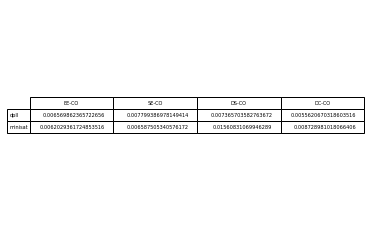

In [56]:
benchmark(solvers=["dpll","minisat"],semantics=["CO"],input="../examples/tgf.txt")

In [57]:
print(rubens_checker("SE-CO","/home/christophe/rubensTest",rubensJar))

23:40:50 [INFO ] RUBENS-CHK: 
23:40:50 [INFO ] RUBENS-CHK:     Rubens  Copyright (C) 2019  Artois University and CNRS
23:40:50 [INFO ] RUBENS-CHK:     This program comes with ABSOLUTELY NO WARRANTY; for details run with `--license'.
23:40:50 [INFO ] RUBENS-CHK:     This is free software, and you are welcome to redistribute it
23:40:50 [INFO ] RUBENS-CHK:     under certain conditions; run with `--license' for details.
23:40:50 [INFO ] RUBENS-CHK: 
23:40:50 [INFO ] RUBENS-CHK: checking SE-CO
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with status 101
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with status 101
23:40:50 [ERROR] RUBENS-CHK: SE-CO error (1) for instance [[], [], [[]]]: "" is not a valid extension (generation history: EMPTY_AF).
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with status 101
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with status 101
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with status 101
23:40:50 [WARN ] RUBENS-CHK: subprocess exited with stat

In [18]:
print(solve("../examples/tgf.txt", "SE-CO", solvers=["dpll", "minisat"]))

['[1,4,6]\n', 0.009395360946655273]


In [ ]:
print(solve("../examples/tgf.txt", "EE-CO"))

In [ ]:
print(solve("../examples/tgf.txt", "DC-CO", arg="1", solvers=["manysat"]))

In [ ]:
print(solve("../examples/tgf.txt", "DC-CO", arg="3"))

In [11]:
print(solve("../examples/tgf.txt", "DS-CO", arg="1"))

In [12]:
print(solve("../examples/tgf.txt", "DS-CO", arg="3"))

In [25]:
G1 = GR_gen(500,.3)

In [14]:
G2 = ST_gen(100,0,10,0,10,0,10,.3)

In [26]:
tofile(G1,"test.txt")

In [27]:
print(solve("test.txt", "SE-CO", solvers=["dpll", "minisat"]))

[479,465,463,422,462,395,324,269,474,414,464,477,480,49]



In [28]:
print(solve("test.txt", "SE-CO", solvers=["dpll"]))

[477,479,463,480,465,422,474,462,414,395,324,269,464,49]



In [29]:
print(solve("test.txt", "SE-CO", solvers=["minisat"]))

[464,479,324,480,474,465,269,463,477,49,462,395,422,414]

